In [1]:
from flask import Flask, request, render_template, redirect,send_file, make_response
# from flask import Flask, request, render_template, session, redirect,send_file, make_response
from cloudant.client import Cloudant
import pandas as pd
import matplotlib.pyplot as plt
import io
import random
from flask import Response
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import base64
from matplotlib.backends.backend_pdf import PdfPages
import pypandoc
import requests
# from flask_session import Session
# from flask.ext.session import Session
from redis import Redis
import redis
import os
import urllib.parse
from urllib.parse import parse_qsl, urljoin, urlparse
from base64 import b64encode

import numpy
import pytesseract
import matplotlib.pyplot as plt
import cv2
pytesseract.pytesseract.tesseract_cmd = r"/usr/local/Cellar/tesseract/4.1.1/bin/tesseract"
import cv2


In [2]:
app = Flask(__name__,template_folder='templates')


In [3]:
@app.route('/')
def home():
    return render_template('login.html')

@app.route('/upload',methods=['GET','POST'])
def upload():
    if(request.form['username'] == 'user' and request.form['password'] == 'user' ):
        return render_template('upload.html')
    
@app.route('/x', methods=['POST'])
def x():
#     print("hello1")
    param={'username':"4a366964-f520-4ba2-afba-9a1b374f4277-bluemix",'api':"4FpjCCjAVftwY8ZLZDSUJa_8iG14u0c0VsXPB-YEhrU6"}
    db_username = param['username']  
    api = param['api'] 
    databaseName = "vehicle"
#     print("hello")
    
    client = Cloudant.iam(db_username,api, connect = True)
    client.connect()
    my_database = client[databaseName]
    file = request.files['file']
    file_name = file.filename
#     file.save(secure_filename(f.filename))
#     return 'file uploaded successfully'
#     print(file_name)
    uploaded_file_content = b64encode(file.read())
   #for document in my_database:
#     t=session.get('tp_name')
#     t=t.decode("utf-8")
    data = {'username':"user",'file_name': file_name, '_attachments': {file_name : {'data': uploaded_file_content.decode('utf-8')}}}
    my_database.create_document(data)
#     u=session.get('username')
#     g=session.get('globaldb')
#     u=u.decode("utf-8")
#     g=g.decode("utf-8")
    
    return render_template('upload.html')

@app.route('/x1', methods=['POST'])
def x1():
#     print("hello1")
    param={'username':"4a366964-f520-4ba2-afba-9a1b374f4277-bluemix",'api':"4FpjCCjAVftwY8ZLZDSUJa_8iG14u0c0VsXPB-YEhrU6"}
    db_username = param['username']  
    api = param['api'] 
    databaseName = "vehicle"
#     print("hello")
    
    client = Cloudant.iam(db_username,api, connect = True)
    client.connect()
    my_database = client[databaseName]
    file = request.files['file']
    img = base64.b64encode(file.read())
    file_name = file.filename
#     file.save(secure_filename(f.filename))
#     return 'file uploaded successfully'
#     print(file_name)
    uploaded_file_content = b64encode(file.read())
   #for document in my_database:
#     t=session.get('tp_name')
#     t=t.decode("utf-8")
    imageString = base64.b64decode(img)
    data = {'username':"user",'file_name': file_name, '_attachments': {file_name : {'data': uploaded_file_content.decode('utf-8')}}}
    my_database.create_document(data)
#     u=session.get('username')
#     g=session.get('globaldb')
#     u=u.decode("utf-8")
#     g=g.decode("utf-8")
#     plate_img=file
    plate_img = cv2.imdecode(numpy.frombuffer(imageString, numpy.uint8), cv2.COLOR_BGR2GRAY)
#     plate_img=cv2.imread(plate_img)
#     plate_img = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    plate_cascade = cv2.CascadeClassifier('/Users/sanjanasrinivasareddy/Desktop/vehicle_fitness/indian_license_plate.xml')
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)
    for (x,y,w,h) in plate_rect:
        a,b = (int(0.02*plate_img.shape[0]), int(0.025*plate_img.shape[1])) #parameter tuning
        plate = plate_img[y+a:y+h-a, x+b:x+w-b]
    # finally representing the detected contours by drawing rectangles around the edges.
        cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
    ret,thresh1 = cv2.threshold(plate,120,255,cv2.THRESH_BINARY)

# pytesseract image to string to get results
    text = str(pytesseract.image_to_string(thresh1, config='--psm 6'))
#     print(text)
#     pngImage = io.BytesIO()
#     FigureCanvas(plate_img).print_png(pngImage)
    plate = plate.copy(order='C')
    plate_img = plate_img.copy(order='C')

#     pngImageB64String = "data:image/png;base64,"
#     pngImageB64String += base64.b64encode(plate_img).decode('utf8')
#     pngImage = io.BytesIO()
#     FigureCanvas(plate).print_png(pngImage)
#     pngImageB64String1 = "data:image/jpg;base64,"
#     pngImageB64String1 += base64.b64encode(plate).decode('utf8')
    cv2.imwrite('/Users/sanjanasrinivasareddy/Desktop/vehicle_fitness/test.jpg', plate)
    return render_template('upload.html',message=text)

    if(request.form['username'] == 'user' and request.form['password'] == 'user' ):
        return render_template('upload.html')

In [ ]:
if __name__ == '__main__':
    app.run(debug=True,use_reloader=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [31/Oct/2020 15:08:59] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Oct/2020 15:09:03] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [31/Oct/2020 15:09:03] "GET /Users/sanjanasrinivasareddy/Desktop/vehicle_fitness/test.jpg HTTP/1.1" 404 -
127.0.0.1 - - [31/Oct/2020 15:09:17] "POST /x1 HTTP/1.1" 200 -
127.0.0.1 - - [31/Oct/2020 15:09:17] "GET /Users/sanjanasrinivasareddy/Desktop/vehicle_fitness/test.jpg HTTP/1.1" 404 -
127.0.0.1 - - [31/Oct/2020 15:09:28] "POST /x1 HTTP/1.1" 200 -
127.0.0.1 - - [31/Oct/2020 15:09:28] "GET /Users/sanjanasrinivasareddy/Desktop/vehicle_fitness/test.jpg HTTP/1.1" 404 -
127.0.0.1 - - [31/Oct/2020 15:10:05] "POST /x1 HTTP/1.1" 200 -
127.0.0.1 - - [31/Oct/2020 15:10:05] "GET /Users/sanjanasrinivasareddy/Desktop/vehicle_fitness/puc%20images/plate.jpg HTTP/1.1" 404 -
127.0.0.1 - - [31/Oct/2020 15:10:13] "POST /x1 HTTP/1.1" 200 -
127.0.0.1 - - [31/Oct/2020 15:10:13] "GET /Users/sanjanasrinivasare

In [5]:
plate_img="/Users/sanjanasrinivasareddy/Desktop/vehicle_fitness/puc images/plate.jpg"
plate_img=cv2.imread(plate_img)
plate_img = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
plate_cascade = cv2.CascadeClassifier('/Users/sanjanasrinivasareddy/Desktop/vehicle_fitness/indian_license_plate.xml')
plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)
for (x,y,w,h) in plate_rect:
    a,b = (int(0.02*plate_img.shape[0]), int(0.025*plate_img.shape[1])) #parameter tuning
    plate = plate_img[y+a:y+h-a, x+b:x+w-b]
# finally representing the detected contours by drawing rectangles around the edges.
    cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
ret,thresh1 = cv2.threshold(plate,120,255,cv2.THRESH_BINARY)

# pytesseract image to string to get results
text = str(pytesseract.image_to_string(thresh1, config='--psm 6'))
#     print(text)
#     pngImage = io.BytesIO()
#     FigureCanvas(plate_img).print_png(pngImage)
plate = plate.copy(order='C')
plate_img = plate_img.copy(order='C')

pngImageB64String = "data:image/png;base64,"
pngImageB64String += base64.b64encode(plate_img).decode('utf8')
#     pngImage = io.BytesIO()
#     FigureCanvas(plate).print_png(pngImage)
pngImageB64String1 = "data:image/png;base64,"
pngImageB64String1 += base64.b64encode(plate).decode('utf8')

In [7]:
pngImageB64String1

''

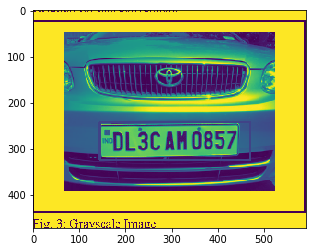

In [10]:
plt.imshow(plate_img)